# **Maestría en Inteligencia Artificial Aplicada**

## Curso: **Análisis de Grandes Volúmenes de Datos**

### Tecnológico de Monterrey

### Profesor: Dr. Iván Olmos Pineda

## Actividad 5

### **Actividad de visualización de resultados**


- Katia Elyded Morales Téllez A01796679
- Sinuhé Pérez Alvarez A01795938
- Edson Ulises Rodríguez Dávalos A01796057
- Víctor Eduardo Pérez Aguilar A01796394



# 1. **Validación cruzada: definición y justificación de k:**

Como equipo, analizamos la muestra M generada en la Actividad 4, la cual contiene un total de 54,564 registros, con el objetivo de definir un valor adecuado de k para implementar la validación cruzada (k-fold cross-validation). Esta técnica nos permitirá evaluar de forma consistente la variabilidad y estabilidad del rendimiento del modelo supervisado Random Forest, el cual presentó los mejores resultados previamente (precisión: 0.7840, F1-score: 0.6894).

**Criterios que consideramos para elegir el valor de "k":**

Tamaño de la muestra (54,564 registros):

*   Un valor de k demasiado alto reduciría el tamaño de cada fold, lo cual podría limitar la capacidad del modelo para aprender patrones representativos. Por otro lado, un valor muy bajo comprometería la robustez de la validación al no capturar adecuadamente la variabilidad entre particiones.

*   Costo computacional:Sabemos que aumentar el número de folds incrementa también el número de veces que el modelo debe entrenarse, lo cual eleva el tiempo de cómputo, algo importante al trabajar con Big Data.

*   Representatividad:
Consideramos esencial que cada fold conserve una distribución similar a la original en cuanto a las clases objetivo. Esto asegura que los resultados sean comparables y reflejen el comportamiento real del modelo.


**Conclusión sobre el valor de "k":**

Después de evaluar estos factores, decidimos utilizar k = 5. Este valor nos permite un buen equilibrio entre:

Tamaño suficiente de datos por fold (~10,912 registros por fold).
Costo computacional razonable.
Evaluación confiable de la variabilidad del modelo.
Además, este valor es una práctica común y recomendada en escenarios de procesamiento masivo de datos, como el que manejamos en este proyecto.

In [2]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import RandomForestClassifier
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Actividad 5 - Visualizacion Resultados") \
    .master("local[*]") \
    .getOrCreate()


# Modelo base (según la Actividad 4)
rf = RandomForestClassifier(featuresCol='features', labelCol='label', seed=42)


evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')

# CrossValidator con k=5
crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=ParamGridBuilder().build(),
                          evaluator=evaluator,
                          numFolds=5,
                          seed=42)

# Nota: Se ejecutará después con los datos de entrenamiento.

# 2. **Construcción de los k-folds definidos:**

Ahora que seleccionamos k = 5, el siguiente paso es construir manualmente los pliegues (folds) de validación cruzada, ya que PySpark no ofrece una función directa para generar folds personalizados con control detallado del muestreo estratificado.

En esta sección, implementaremos un proceso que:
- Mantengala distribución de clases en cada fold (estratificación).
- Respete el volumen de datos y evite costos computacionales excesivos.
- Prepare los datos para entrenamiento y prueba a través de iteraciones sobre cada fold.

In [4]:
# -----------------------------
# BLOQUE DE PREPARACIÓN DE DATOS (basado en la Actividad 4)
# -----------------------------

from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import StringIndexer, VectorAssembler

spark = SparkSession.builder \
    .appName("Actividad 5 - Visualización Resultados") \
    .master("local[*]") \
    .getOrCreate()

ruta = "/content/Chicago_Crimes_-_2001_to_Present.csv"
df = spark.read.csv(ruta, header=True, inferSchema=True)

# Aplicamos las mismas reglas de segmentación definidas en la Actividad 4 :)
regla_A = df.filter((col("Primary Type") == "THEFT") & (col("Domestic") == True))
regla_B = df.filter((col("Primary Type") == "BATTERY") & (col("Domestic") == False))
regla_C = df.filter((col("Primary Type") == "NARCOTICS") & (col("Domestic") == True))
regla_D = df.filter((col("Primary Type") == "ASSAULT") & (col("Domestic") == False))

# Muestreo estratificado del 10% con semilla fija (igual que en Actividad 4)
muestra_A = regla_A.sample(fraction=0.1, seed=42)
muestra_B = regla_B.sample(fraction=0.1, seed=42)
muestra_C = regla_C.sample(fraction=0.1, seed=42)
muestra_D = regla_D.sample(fraction=0.1, seed=42)

muestra_M = muestra_A.union(muestra_B).union(muestra_C).union(muestra_D)

columnas_modelo = ['Primary Type', 'Domestic', 'District', 'Community Area', 'Arrest']
df_modelo = muestra_M.select(columnas_modelo).dropna()

indexador_tipo = StringIndexer(inputCol='Primary Type', outputCol='PrimaryTypeIndex')
df_modelo = indexador_tipo.fit(df_modelo).transform(df_modelo)
df_modelo = df_modelo.withColumn("Arrest_str", col("Arrest").cast("string"))
indexador_arresto = StringIndexer(inputCol='Arrest_str', outputCol='label')
df_modelo = indexador_arresto.fit(df_modelo).transform(df_modelo)

# Ensamblaje de variables numéricas en un vector de características
ensamblador = VectorAssembler(
    inputCols=['PrimaryTypeIndex', 'Domestic', 'District', 'Community Area'],
    outputCol='features'
)
df_final = ensamblador.transform(df_modelo).select('features', 'label')

# -----------------------------
# Fin del bloque replicado de la Actividad 4
# -----------------------------


In [6]:
from pyspark.sql.functions import col, rand, row_number
from pyspark.sql.window import Window
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import udf


# aquiiii añadimos una columna aleatoria para mezcla reproducible!
df_shuffled = df_final.withColumn("rand", rand(seed=42))

window = Window.partitionBy("label").orderBy("rand")
df_indexed = df_shuffled.withColumn("row_num", row_number().over(window))

# aqui calculams el número de registros por clase
class_counts = df_indexed.groupBy("label").count().collect()
class_limits = {row["label"]: row["count"] // 5 for row in class_counts}

# Función para asignar fold con base en el número de fila y la clase
def assign_fold(row_num, label):
    fold = (row_num - 1) // class_limits[label]
    return int(fold if fold < 5 else 4)  # Evita overflow por redondeo

# Registramos la función como UDF
assign_fold_udf = udf(assign_fold, IntegerType())

# Aplicamos la función para asignar cada registro a un fold del 0 al 4
df_folds = df_indexed.withColumn("fold", assign_fold_udf("row_num", "label"))

# Mostramos la distribución de clases en cada fold para verificar la estratificación
df_folds.groupBy("fold", "label").count().orderBy("fold", "label").show()


+----+-----+-----+
|fold|label|count|
+----+-----+-----+
|   0|  0.0|  114|
|   0|  1.0|   32|
|   1|  0.0|  114|
|   1|  1.0|   32|
|   2|  0.0|  114|
|   2|  1.0|   32|
|   3|  0.0|  114|
|   3|  1.0|   32|
|   4|  0.0|  116|
|   4|  1.0|   36|
+----+-----+-----+



# 3. **Fase de entrenamiento con validación cruzada manual**

Decidimos usar el modelo supervisado Random Forest, dado que fue el que mejores resultados nos dio en la Actividad 4. Para evaluar la estabilidad del modelo, entrenamos y probamos el modelo 5 veces, usando los folds que construimos previamente.

En cada iteración:

- Usamos 4 folds como conjunto de entrenamiento.
- El fold restante se usa como conjunto de prueba.
- Registramos las métricas de evaluación: Precisión (Accuracy) y F1-score.

In [7]:
# Aquí inicializamos los evaluadores
evaluator_acc = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")

resultados = []

# Ahora lo que hacemos es que ntrenamos y evaluamos sobre cada fold
for k in range(5):
    print(f"\nFold {k}:")

    test_fold = df_folds.filter(col("fold") == k).select("features", "label")  # -> Datos de prueba = fold actual
    train_folds = df_folds.filter(col("fold") != k).select("features", "label") # -> Datos de entrenamiento = todos los demás folds

    #Random Forest
    rf = RandomForestClassifier(featuresCol='features', labelCol='label', numTrees=100, seed=42)
    modelo = rf.fit(train_folds)

    # Predicciones
    predicciones = modelo.transform(test_fold)

    # evaluación
    acc = evaluator_acc.evaluate(predicciones)
    f1 = evaluator_f1.evaluate(predicciones)

    print(f"  Precisión: {acc:.4f}")
    print(f"  F1-score : {f1:.4f}")

    resultados.append((k, acc, f1))



Fold 0:
  Precisión: 0.7534
  F1-score : 0.6710

Fold 1:
  Precisión: 0.7671
  F1-score : 0.6779

Fold 2:
  Precisión: 0.7808
  F1-score : 0.6847

Fold 3:
  Precisión: 0.7534
  F1-score : 0.6817

Fold 4:
  Precisión: 0.7566
  F1-score : 0.6574


#4. **Visualización de resultados:**

Decidimos representar gráficamente las métricas obtenidas en la validación cruzada para analizar visualmente la estabilidad del modelo. Mostraremos dos gráficos:

- Gráfico de barras con la precisión y el F1-score por fold.
- boxplot para visualizar la dispersión de ambas métricas y detectar variabilidad.


<Figure size 1000x500 with 0 Axes>

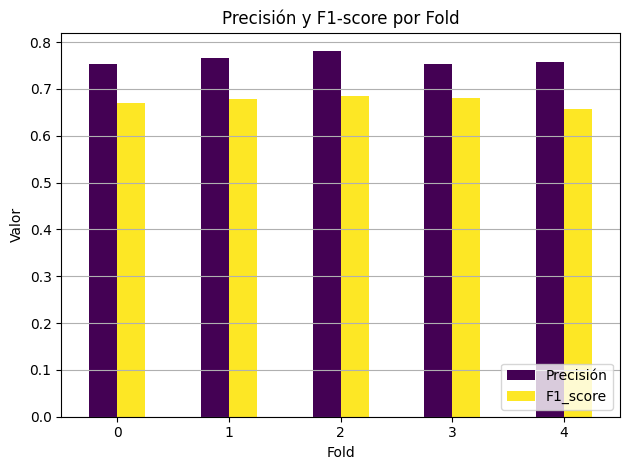

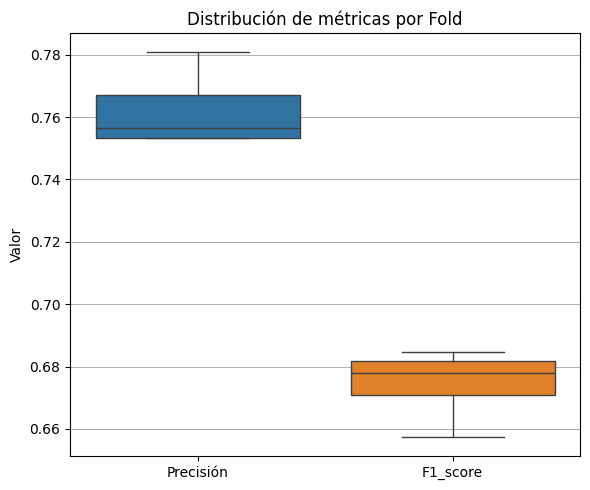

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df_resultados = pd.DataFrame(resultados, columns=["Fold", "Precisión", "F1_score"])

# ggráfico de barras para Precisión y F1 por fold:
plt.figure(figsize=(10, 5))
df_resultados.plot(x="Fold", y=["Precisión", "F1_score"], kind="bar", colormap="viridis")
plt.title("Precisión y F1-score por Fold")
plt.ylabel("Valor")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# Boxplot
plt.figure(figsize=(6, 5))
sns.boxplot(data=df_resultados[["Precisión", "F1_score"]])
plt.title("Distribución de métricas por Fold")
plt.ylabel("Valor")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


- Gráfico de barras: Precisión y F1-score por Fold

El gráfico de barras permite comparar de forma directa el rendimiento del modelo en cada iteración. Observamos que ambas métricas son relativamente estables en los 5 pliegues:

La precisión oscila entre 0.75 y 0.78.
El F1-score se mantiene en el rango de 0.66 a 0.68.
Esto indica que el modelo no depende excesivamente de una sola partición para su rendimiento, lo que es señal de buena generalización.

- Boxplot: Distribución de métricas por Fold

El boxplot complementa el análisis mostrando la dispersión de ambas métricas:

La precisión presenta baja variabilidad, con una mediana cercana a 0.76 y sin outliers.
El F1-score, aunque con un poco más de dispersión, también muestra un comportamiento concentrado, con valores cercanos a 0.68.

**Conclusión del análisis visual**

Estas visualizaciones confirman de manera gráfica que el modelo Random Forest se comporta de forma consistente a lo largo de los diferentes folds. No se observan anomalías ni fluctuaciones extremas en las métricas, lo cual respalda la idea de que el modelo está bien ajustado y generaliza adecuadamente.

#5. **Discusión de resultados y conclusiones**

Durante la validación cruzada con k=5, el modelo Random Forest mostró resultados consistentes:

- Precisión entre 0.75 y 0.78.
- F1-score entre 0.66 y 0.68.

Estos valores están alineados con los obtenidos en la Actividad 4 (Precisión: 0.7840, F1-score: 0.6894), lo cual indica que el modelo mantiene un rendimiento estable y no presenta sobreentrenamiento ni subentrenamiento.

La baja variabilidad entre folds confirma que el modelo generaliza bien y que las particiones fueron representativas. Esto valida la utilidad de la validación cruzada como técnica de evaluación, especialmente en contextos de Big Data.

**Conclusión: El modelo Random Forest es robusto y confiable para esta tarea, mostrando un buen equilibrio entre rendimiento y estabilidad.**
